# <a id="1"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">1. Setup</div>

<a id="1.1"></a>
# <b><span style='color:#8D6D9B'>1.1. Package and Library</span></b>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
import random
import shutil             # to copy images to another directory
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import Xception
from sklearn.metrics import classification_report , confusion_matrix,roc_curve, auc , f1_score, precision_score, recall_score
from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing, Activation, add, GlobalAveragePooling2D,Dropout,Flatten
from keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

plt.style.use('ggplot')

***Hyperparameter***

In [2]:
N_CLASSES = 6
EPOCHS = 50
LEARNING_RATE = 1e-4
RESNET50_IMG_SIZE = (224,224)
XCEPTION_IMG_SIZE = (299,299)
DENSENET_IMG_SIZE = (224,224)
BATCH_SIZE = 64

<a id="1.2"></a>
# <b><span style='color:#8D6D9B'>1.2. Load The Data</span></b>

In [3]:
dataDirList = ['/kaggle/input/garbage-classification/Garbage classification/Garbage classification/' ,
              '/kaggle/input/d/mostafaabla/garbage-classification/garbage_classification/']

selectedClasses = ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic' ,'white-glass']

In [4]:
imgPaths = []
labels = []
for dataDir in dataDirList:
    for className in os.listdir(dataDir):
        if className in selectedClasses :
            classPath = os.path.join(dataDir,className)
            for img in os.listdir(classPath):
                imgPath = os.path.join(classPath,img)
                imgPaths.append(imgPath)
                if className == 'white-glass':
                    className = 'glass'
                labels.append(className)

# Convert the 2 lists to dataframe to easy use
df = pd.DataFrame({
    'imgPath':imgPaths,
    'label':labels
})

df = df.sample(frac=1).reset_index(drop=True)            # Shuffle

df

,imgPath,label
0,/kaggle/input/d/mostafaabla/garbage-classifica...,plastic
1,/kaggle/input/d/mostafaabla/garbage-classifica...,paper
2,/kaggle/input/garbage-classification/Garbage c...,metal
3,/kaggle/input/d/mostafaabla/garbage-classifica...,glass
4,/kaggle/input/d/mostafaabla/garbage-classifica...,paper
...,...,...
7569,/kaggle/input/garbage-classification/Garbage c...,trash
7570,/kaggle/input/d/mostafaabla/garbage-classifica...,trash
7571,/kaggle/input/d/mostafaabla/garbage-classifica...,paper
7572,/kaggle/input/d/mostafaabla/garbage-classifica...,metal


# <a id="2"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">2. Spliting</div>

In [5]:
# get the ratio such as 15% of each class for testing
def DataFrameSpliting(df , ratio , classesList):

    trainDf = pd.DataFrame(columns = ['imgPath','label'])
    testDf = pd.DataFrame(columns = ['imgPath','label'])
    for clas in classesList :
        tempDf = df[df['label'] == clas]
        lastIndex = int(len(tempDf) * ratio)
        trainClassDf = tempDf[:lastIndex]
        testClassDf = tempDf[lastIndex:]
        trainDf = pd.concat([trainDf , trainClassDf] , axis=0)
        testDf = pd.concat([testDf , testClassDf] , axis=0)

    return trainDf.sample(frac=1).reset_index(drop=True) , testDf.sample(frac=1).reset_index(drop=True)  # shuffling , reset index

In [6]:
classList = list(df['label'].unique())
trainDf , testDf = DataFrameSpliting(df , 0.85 , classList)
validationDf ,testDf  = DataFrameSpliting(testDf , 0.6 , classList)

In [7]:
trainDf.head()

,imgPath,label
0,/kaggle/input/d/mostafaabla/garbage-classifica...,plastic
1,/kaggle/input/d/mostafaabla/garbage-classifica...,cardboard
2,/kaggle/input/garbage-classification/Garbage c...,cardboard
3,/kaggle/input/d/mostafaabla/garbage-classifica...,paper
4,/kaggle/input/d/mostafaabla/garbage-classifica...,trash


In [8]:
trainDf['label'].value_counts()

label
paper        1397
plastic      1144
cardboard    1099
glass        1084
metal        1002
trash         708
Name: count, dtype: int64

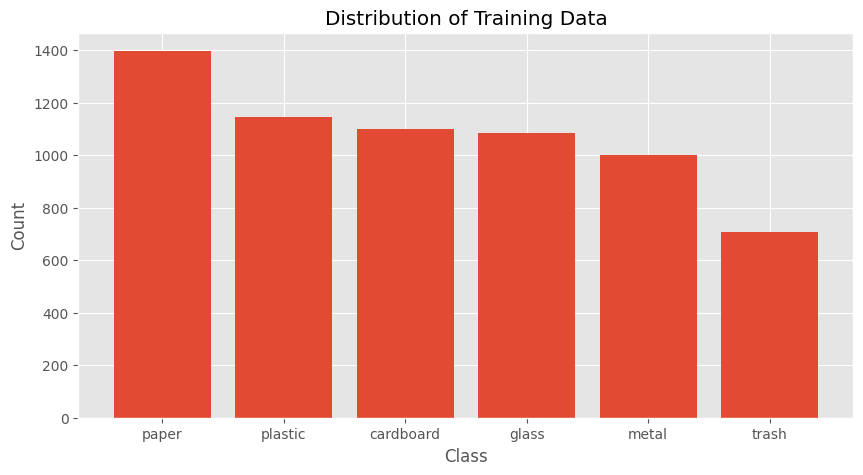

In [9]:
plt.figure(figsize=(10,5))
plt.bar(trainDf['label'].value_counts().index , trainDf['label'].value_counts())
plt.title('Distribution of Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [10]:
validationDf.head()

,imgPath,label
0,/kaggle/input/d/mostafaabla/garbage-classifica...,plastic
1,/kaggle/input/garbage-classification/Garbage c...,paper
2,/kaggle/input/d/mostafaabla/garbage-classifica...,paper
3,/kaggle/input/garbage-classification/Garbage c...,paper
4,/kaggle/input/garbage-classification/Garbage c...,paper


In [11]:
validationDf['label'].value_counts()

label
paper        148
plastic      121
cardboard    117
glass        115
metal        106
trash         75
Name: count, dtype: int64

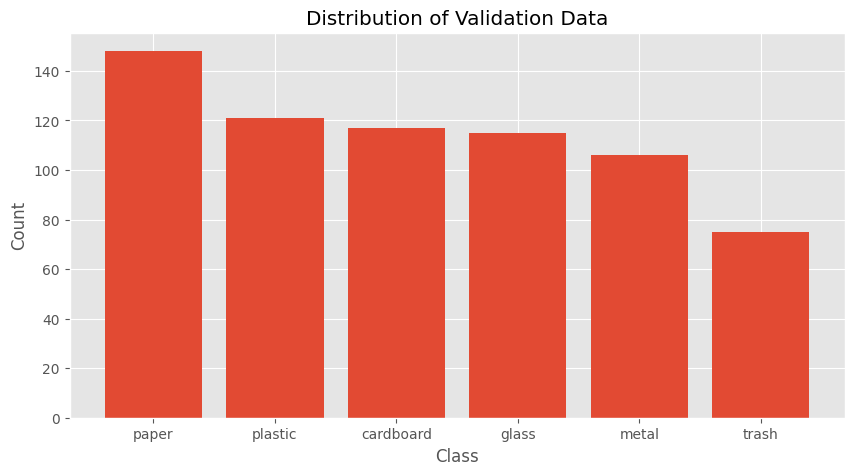

In [12]:
plt.figure(figsize=(10,5))
plt.bar(validationDf['label'].value_counts().index , validationDf['label'].value_counts())
plt.title('Distribution of Validation Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [13]:
testDf.head()

,imgPath,label
0,/kaggle/input/d/mostafaabla/garbage-classifica...,cardboard
1,/kaggle/input/d/mostafaabla/garbage-classifica...,trash
2,/kaggle/input/garbage-classification/Garbage c...,plastic
3,/kaggle/input/d/mostafaabla/garbage-classifica...,paper
4,/kaggle/input/d/mostafaabla/garbage-classifica...,cardboard


In [14]:
testDf['label'].value_counts()

label
paper        99
plastic      82
cardboard    78
glass        77
metal        71
trash        51
Name: count, dtype: int64

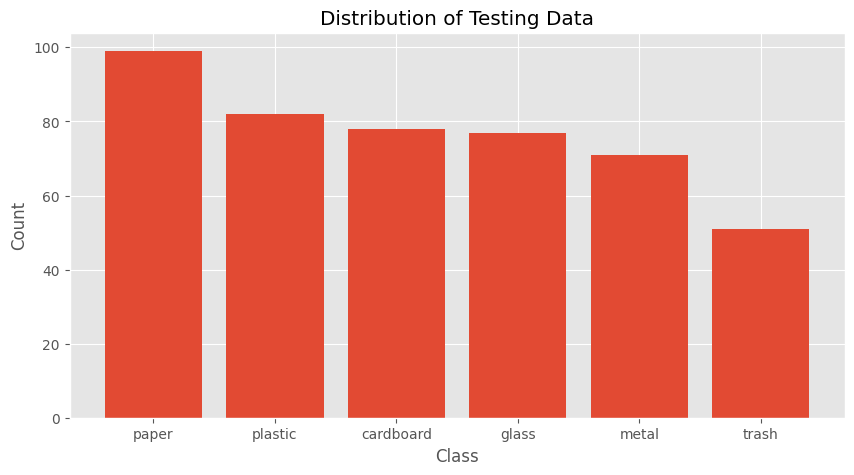

In [15]:
plt.figure(figsize=(10,5))
plt.bar(testDf['label'].value_counts().index , testDf['label'].value_counts())
plt.title('Distribution of Testing Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# <a id="3"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">3. Data Explorations</div>

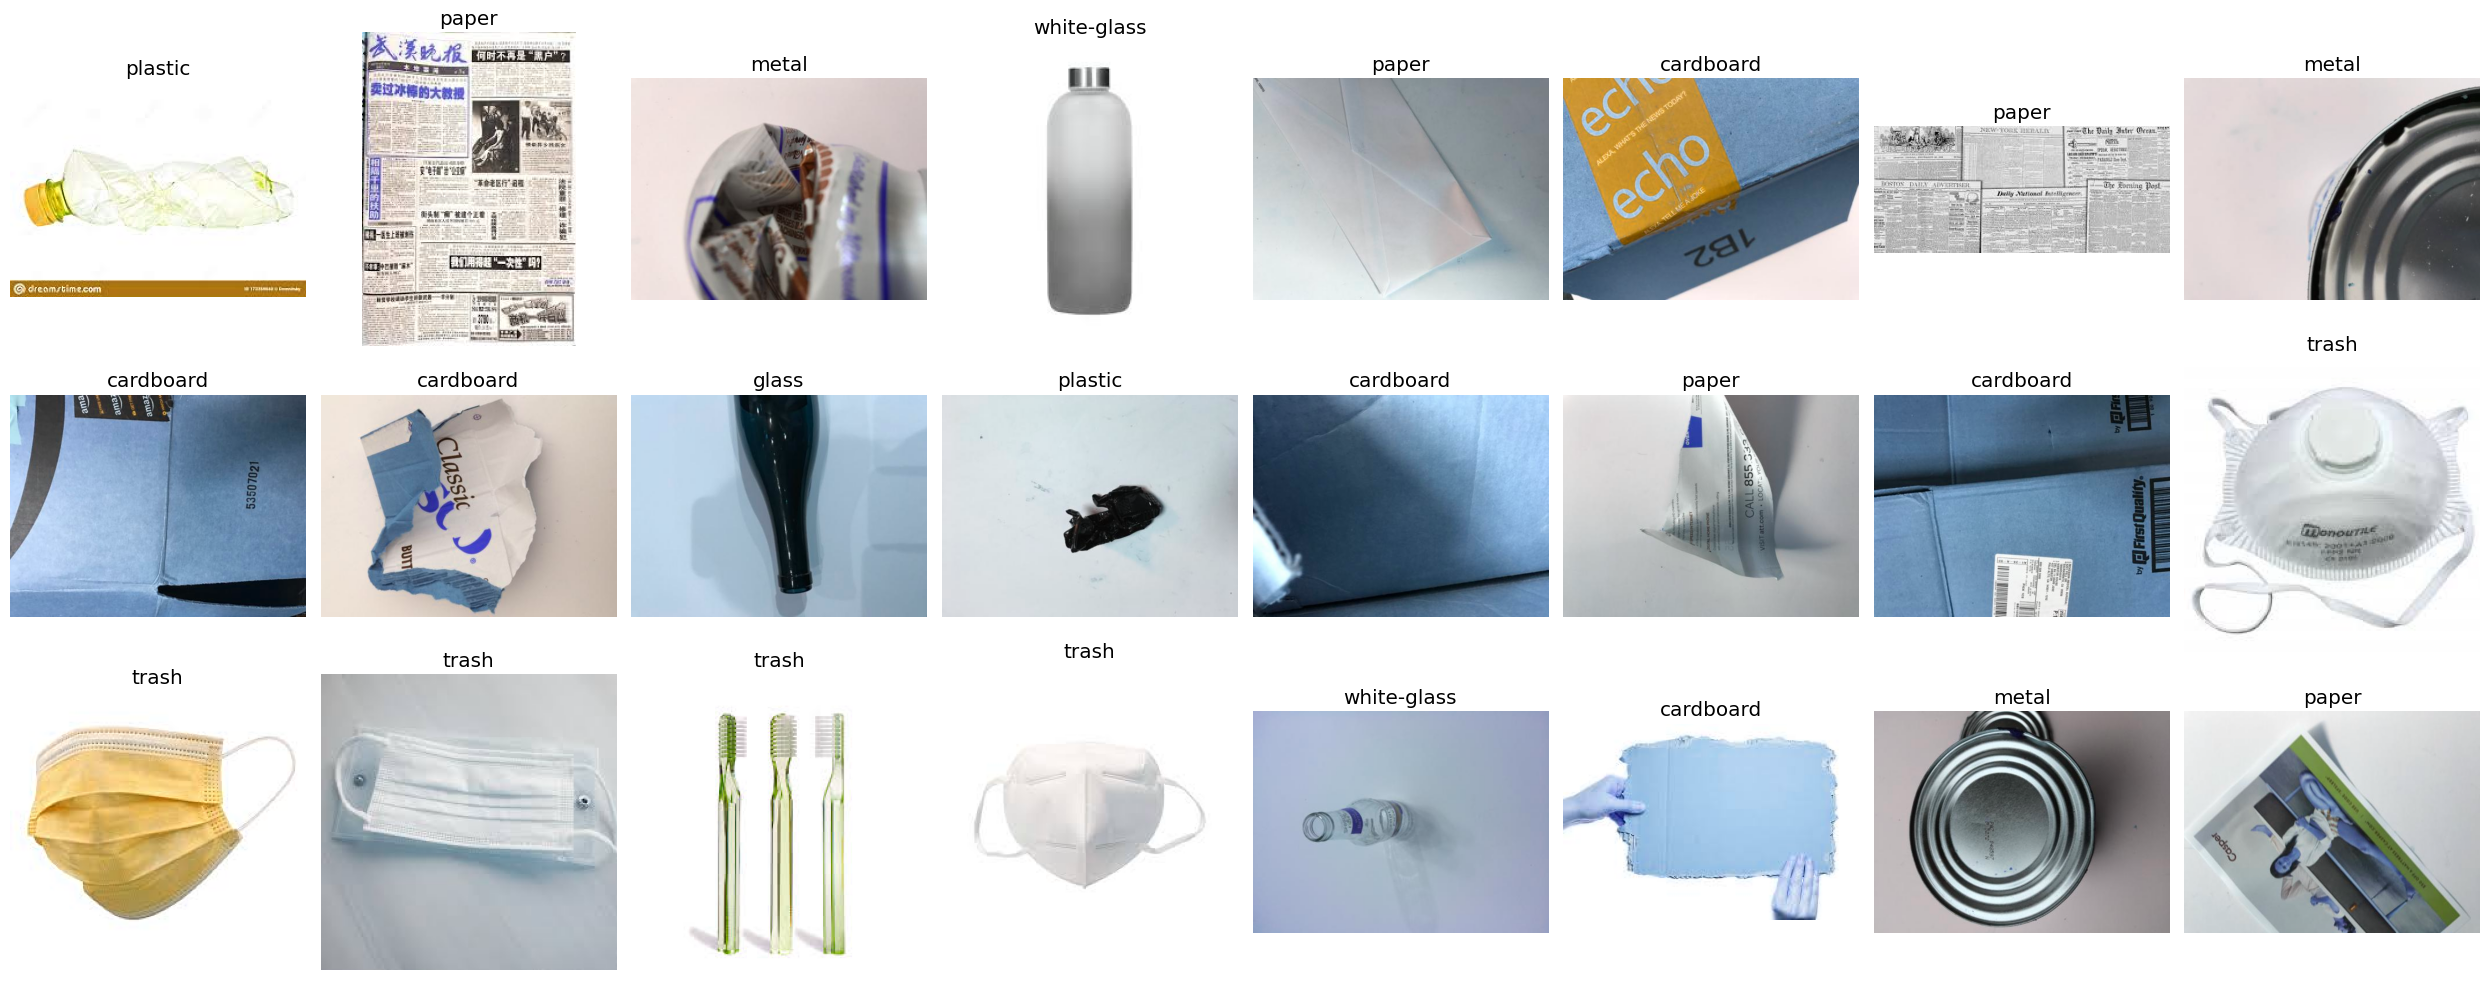

In [16]:
imgPaths = df['imgPath']
fig, axs = plt.subplots(3, 8, figsize=(25, 10))

axs = axs.flatten()

for ax,imgPath in zip(axs , imgPaths):
    label = str(imgPath).split('/')[-2]    # extract label of an imgae from a path
    img = cv2.imread(imgPath)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

# <a id="4"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">4. Data Augmentation</div>

In [17]:
datagenTrain = ImageDataGenerator(
            rescale=1./255,
            zoom_range=(7.0, 1.0),   # zoom in
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=45,
)
datagenVal = ImageDataGenerator(rescale=1./255)
datagenTest = ImageDataGenerator( rescale=1./255 )

In [18]:
def Apply_Data_Augmentation(IMG_SIZE):
    
    trainGenerator = datagenTrain.flow_from_dataframe(
        trainDf ,
        x_col='imgPath',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE ,                    # Generate 64 image from the datagenTrain (flipped , rotated , zoomed , ....)  at once
        class_mode='categorical',
        shuffle=True
    )
    
    valGenerator = datagenVal.flow_from_dataframe(
        validationDf ,
        x_col='imgPath',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE ,
        class_mode='categorical',
        shuffle=False
    )
    
    testGenerator = datagenTest.flow_from_dataframe(
        testDf,
        x_col='imgPath',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False  # No shuffling for validation
    )
    return trainGenerator,valGenerator,testGenerator

# <a id="5"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">5. Modeling </div>

# <a id="6"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">6. ResNet architecture from scratch  </div>

In [19]:
def conv_block(x,filters,kernel_size,strides,padding='same'):
  x=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding)(x)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)
  return x

In [20]:
def identity_block(x,filters):
  shortcut=x
  x=conv_block(x,filters=filters ,kernel_size=(1,1),strides=(1,1))
  x=conv_block(x,filters=filters ,kernel_size=(3,3),strides=(1,1))
  x=Conv2D(filters=filters *4 ,kernel_size=(1,1),strides=(1,1))(x)
  x=BatchNormalization()(x)
  x=add([x,shortcut])
  x=Activation('relu')(x)
  return x

def projection_block(x,filters,stride = (1,1)):
  shortcut=x
  x=conv_block(x,filters=filters,kernel_size=(1,1),strides = stride)
  x=conv_block(x,filters=filters,kernel_size=(3,3),strides = (1,1))

  x=Conv2D(filters=filters * 4,kernel_size=(1,1),strides=(1,1))(x)
  x=BatchNormalization()(x)
    
  shortcut=Conv2D(filters=filters * 4,kernel_size=(1,1),strides=stride)(shortcut)
  shortcut=BatchNormalization()(shortcut)
    
  x=add([x,shortcut])
  x=Activation('relu')(x)
  return x

In [21]:
def build_model_Resnet50(input_shape,num_classes=6):
  #stage 0
  input=Input(shape=input_shape)
  x=conv_block(input,filters=64,kernel_size=(7,7),strides=(2,2),padding="valid")
  x=MaxPooling2D(pool_size=(3,3),strides=(2,2))(x)
  #stage 1
  x=projection_block(x,filters=64,stride=(1,1))
  x=identity_block(x,filters=64)
  x=identity_block(x,filters=64)
  #stage 2
  x=projection_block(x,filters=128,stride=(2,2))
  x=identity_block(x,filters=128)
  x=identity_block(x,filters=128)
  x=identity_block(x,filters=128)
  #stage 3
  x=projection_block(x,filters=256,stride=(2,2))
  x=identity_block(x,filters=256)
  x=identity_block(x,filters=256)
  x=identity_block(x,filters=256)
  x=identity_block(x,filters=256)
  x=identity_block(x,filters=256)
  #stage 4
  x=projection_block(x,filters=512,stride=(2,2))
  x=identity_block(x,filters=512)
  x=identity_block(x,filters=512)

  x = GlobalAveragePooling2D()(x)
    
  x = Dropout(0.5)(x)
    
  #output layer  
  output=Dense(units=num_classes,activation='softmax')(x)
  model=Model(inputs=input,outputs=output)
  return model

In [22]:
resnet_model = build_model_Resnet50(input_shape=(224,224,3),num_classes=6)

In [23]:
resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 109, 109,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 109, 109,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 54, 54,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 54, 54,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 54, 54,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 54, 54,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ add[0][0]       

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [24]:
resnet_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=5,
                                                 min_lr=1e-7,
                                                 mode='min')

ealystopping=tf.keras.callbacks.EarlyStopping(patience=15,
                                            monitor='val_accuracy',
                                            restore_best_weights=True)

In [26]:
trainGenerator,valGenerator,testGenerator = Apply_Data_Augmentation(RESNET50_IMG_SIZE)
print(f"Training set size: {trainGenerator.samples}")
print(f"Validation set size: {valGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Found 6434 validated image filenames belonging to 6 classes.
Found 682 validated image filenames belonging to 6 classes.
Found 458 validated image filenames belonging to 6 classes.
Training set size: 6434
Validation set size: 682
Testing set size: 458


In [27]:
histroy = resnet_model.fit(
    trainGenerator,
    epochs=EPOCHS,
    validation_data=valGenerator,
    callbacks=[reduce_lr,ealystopping]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734510635.486681      72 service.cc:145] XLA service 0x7d1818003760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734510635.486742      72 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734510666.425094      72 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1734510666.467364      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the

 24/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - accuracy: 0.2158 - loss: 2.4650

I0000 00:00:1734510716.879700      71 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads



101/101 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.2861 - loss: 2.2092 - val_accuracy: 0.1100 - val_loss: 2.1023 - learning_rate: 1.0000e-04
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 91s 837ms/step - accuracy: 0.4201 - loss: 1.6641 - val_accuracy: 0.1188 - val_loss: 2.1795 - learning_rate: 1.0000e-04
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 91s 838ms/step - accuracy: 0.4662 - loss: 1.4778 - val_accuracy: 0.2757 - val_loss: 2.1671 - learning_rate: 1.0000e-04
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 90s 833ms/step - accuracy: 0.5024 - loss: 1.3775 - val_accuracy: 0.1950 - val_loss: 2.4977 - learning_rate: 1.0000e-04
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 91s 841ms/step - accuracy: 0.5373 - loss: 1.2929 - val_accuracy: 0.3021 - val_loss: 2.1823 - learning_rate: 1.0000e-04
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 91s 840ms/step - accuracy: 0.5615 - loss: 1.1978 - val_accuracy: 0.3446 - val_loss: 1.6590 - learning_rate: 1.0000e-04
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 91s 840ms/step - ac

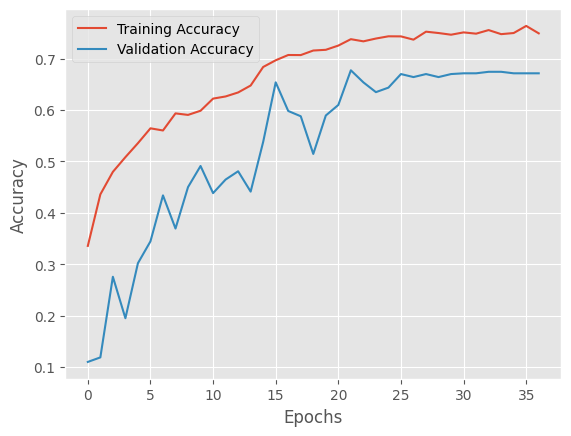

In [28]:
plt.plot(histroy.history['accuracy'],label='Training Accuracy')
plt.plot(histroy.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

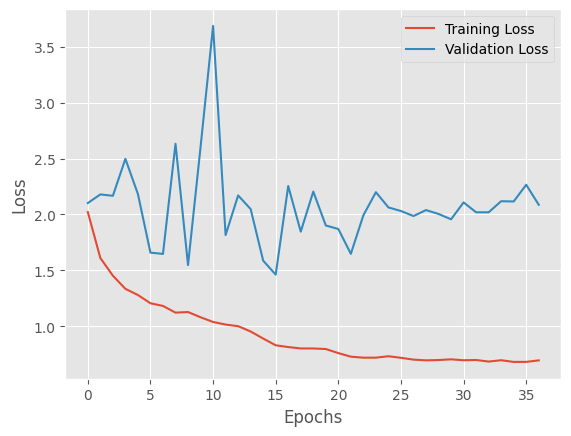

In [29]:
plt.plot(histroy.history['loss'],label='Training Loss')
plt.plot(histroy.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
Resnet50_loss,Resnet50_accuracy=resnet_model.evaluate(testGenerator)
print(f'Loss is {Resnet50_loss}')
print(f'Accuracy is {Resnet50_accuracy}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 551ms/step - accuracy: 0.6700 - loss: 0.9671
Loss is 0.9616246223449707
Accuracy is 0.6768559217453003


In [31]:
all_images = np.concatenate([testGenerator[i][0] for i in range(len(testGenerator))])

In [32]:
y_pred_proba=resnet_model.predict(all_images)

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step


In [33]:
y_pred=np.argmax(y_pred_proba,axis=1)
y_pred[:5]

array([0, 5, 4, 3, 0])

In [34]:
all_labels = np.concatenate([testGenerator[i][1] for i in range(len(testGenerator))])
print(all_labels[:5])

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [35]:
all_labels=np.argmax(all_labels,axis=1)
all_labels[:5]

array([0, 5, 4, 3, 0])

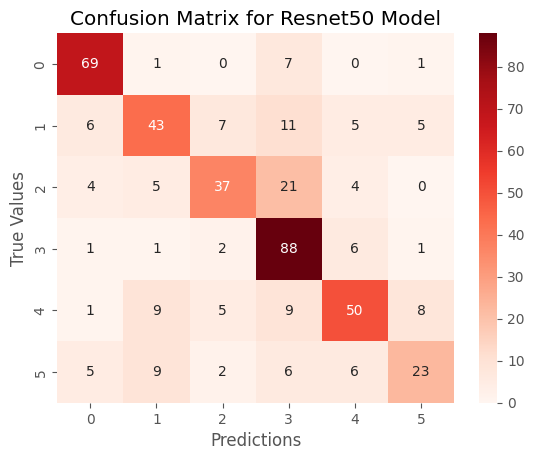

In [36]:
Resnet50_cm=confusion_matrix(all_labels,y_pred)
sns.heatmap(Resnet50_cm,fmt='d',cmap='Reds',annot=True)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('Confusion Matrix for Resnet50 Model')
plt.show()

In [37]:
Resnet50_ClassificationReport = classification_report(all_labels,y_pred)
print('Classification Report for Resnet50 Model is : \n', Resnet50_ClassificationReport)

Classification Report for Resnet50 Model is : 
               precision    recall  f1-score   support

           0       0.80      0.88      0.84        78
           1       0.63      0.56      0.59        77
           2       0.70      0.52      0.60        71
           3       0.62      0.89      0.73        99
           4       0.70      0.61      0.65        82
           5       0.61      0.45      0.52        51

    accuracy                           0.68       458
   macro avg       0.68      0.65      0.66       458
weighted avg       0.68      0.68      0.67       458



In [38]:
from sklearn.metrics import f1_score, precision_score, recall_score


Resnet50_f1 = f1_score(all_labels, y_pred, average='macro')
Resnet50_precision = precision_score(all_labels, y_pred, average='macro')  
Resnet50_recall = recall_score(all_labels, y_pred, average='macro') 

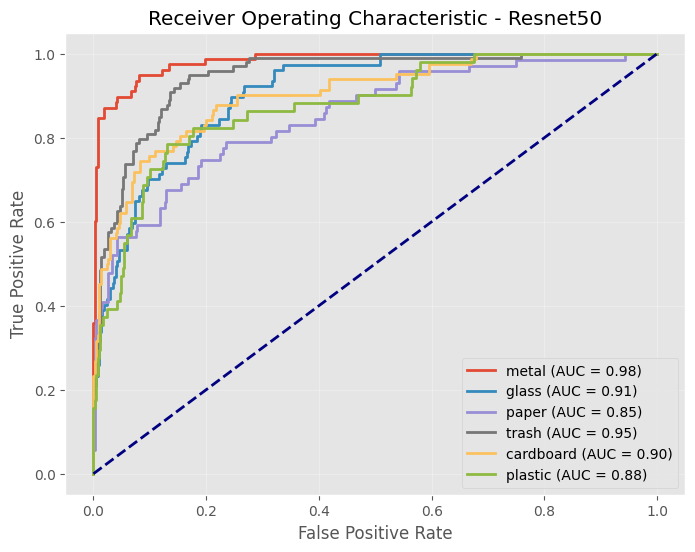

In [39]:
y_true_bin = label_binarize(all_labels, classes=np.arange(N_CLASSES))
    
plt.figure(figsize=(8, 6))
    

for i in range(N_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    label = selectedClasses[i]
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Resnet50')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()



In [40]:
resnet_model.save('resnet50_model.h5')

# <a id="7"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">7. Xception as pre-trained  </div>

In [41]:
xception_model=Xception(weights='imagenet',include_top=False,input_shape=(299,299,3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [42]:
for layer in xception_model.layers:
    layer.trainable = False

In [43]:
xception=Sequential([
    xception_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dense(N_CLASSES,activation='softmax')
])

In [44]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=5,
                                                 min_lr=1e-7,
                                                 mode='min')

ealystopping=tf.keras.callbacks.EarlyStopping(patience=15,
                                            monitor='val_accuracy',
                                            restore_best_weights=True)

In [45]:
xception.compile(optimizer=Adam(learning_rate=LEARNING_RATE),loss='categorical_crossentropy',metrics=['accuracy'])

In [46]:
trainGenerator,valGenerator,testGenerator = Apply_Data_Augmentation(XCEPTION_IMG_SIZE)
print(f"Training set size: {trainGenerator.samples}")
print(f"Validation set size: {valGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Found 6434 validated image filenames belonging to 6 classes.
Found 682 validated image filenames belonging to 6 classes.
Found 458 validated image filenames belonging to 6 classes.
Training set size: 6434
Validation set size: 682
Testing set size: 458


In [47]:
histroy = xception.fit(
    trainGenerator,
    epochs=EPOCHS,
    validation_data=valGenerator,
    callbacks=[reduce_lr,ealystopping]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.4113 - loss: 1.4982 - val_accuracy: 0.7405 - val_loss: 0.8708 - learning_rate: 1.0000e-04
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.6290 - loss: 1.0165 - val_accuracy: 0.7698 - val_loss: 0.7330 - learning_rate: 1.0000e-04
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6778 - loss: 0.9123 - val_accuracy: 0.7801 - val_loss: 0.6848 - learning_rate: 1.0000e-04
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.6756 - loss: 0.8827 - val_accuracy: 0.7507 - val_loss: 0.7248 - learning_rate: 1.0000e-04
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6998 - loss: 0.8382 - val_accuracy: 0.7771 - val_loss: 0.6496 - learning_rate: 1.0000e-04
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6841 - loss: 0.8378 - val_accuracy: 0.7786 - val_loss: 0.6491 - learning_rate: 1.0000e-04
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.72

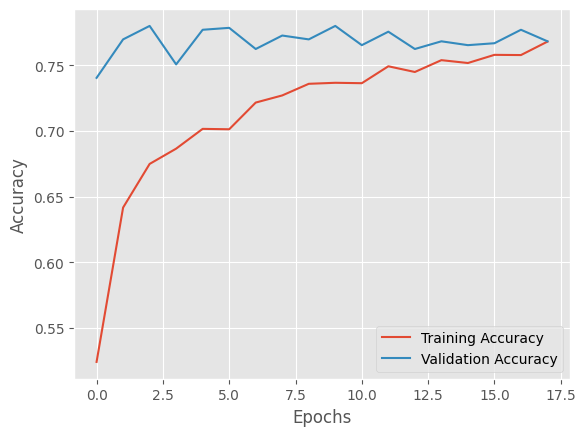

In [48]:
plt.plot(histroy.history['accuracy'],label='Training Accuracy')
plt.plot(histroy.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

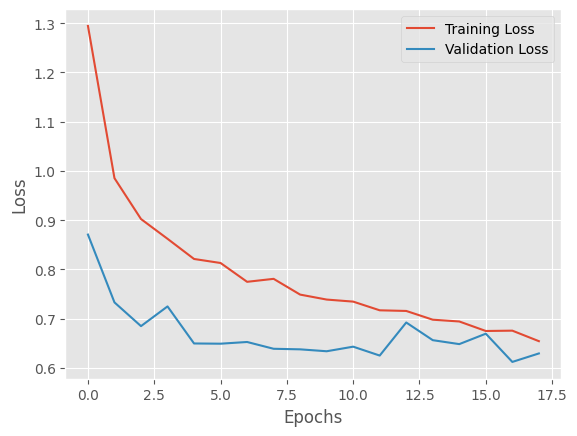

In [49]:
plt.plot(histroy.history['loss'],label='Training Loss')
plt.plot(histroy.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
Xception_loss,Xception_accuracy=xception.evaluate(testGenerator)
print(f'Loss is {Xception_loss}')
print(f'Accuracy is {Xception_accuracy}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 751ms/step - accuracy: 0.7876 - loss: 0.7160
Loss is 0.6855673789978027
Accuracy is 0.7903929948806763


In [51]:
all_images = np.concatenate([testGenerator[i][0] for i in range(len(testGenerator))])

In [52]:
y_pred_proba=xception.predict(all_images)

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step


In [53]:
y_pred=np.argmax(y_pred_proba,axis=1)
y_pred[:5]

array([3, 5, 4, 0, 0])

In [54]:
all_labels = np.concatenate([testGenerator[i][1] for i in range(len(testGenerator))])
print(all_labels[:5])

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [55]:
all_labels=np.argmax(all_labels,axis=1)
all_labels[:5]

array([0, 5, 4, 3, 0])

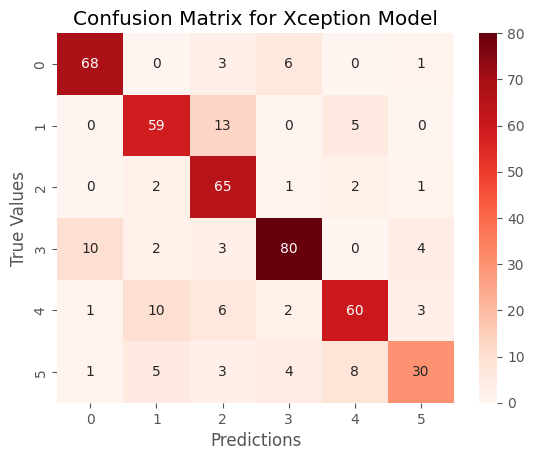

In [56]:
Xception_cm=confusion_matrix(all_labels,y_pred)
sns.heatmap(Xception_cm,fmt='d',cmap='Reds',annot=True)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('Confusion Matrix for Xception Model')
plt.show()

In [57]:
Xception_ClassificationReport = classification_report(all_labels,y_pred)
print('Classification Report for Xception Model is : \n', Xception_ClassificationReport)

Classification Report for Xception Model is : 
               precision    recall  f1-score   support

           0       0.85      0.87      0.86        78
           1       0.76      0.77      0.76        77
           2       0.70      0.92      0.79        71
           3       0.86      0.81      0.83        99
           4       0.80      0.73      0.76        82
           5       0.77      0.59      0.67        51

    accuracy                           0.79       458
   macro avg       0.79      0.78      0.78       458
weighted avg       0.80      0.79      0.79       458



In [58]:
Xception_f1 = f1_score(all_labels, y_pred, average='macro')
Xception_precision = precision_score(all_labels, y_pred, average='macro')  
Xception_recall = recall_score(all_labels, y_pred, average='macro') 

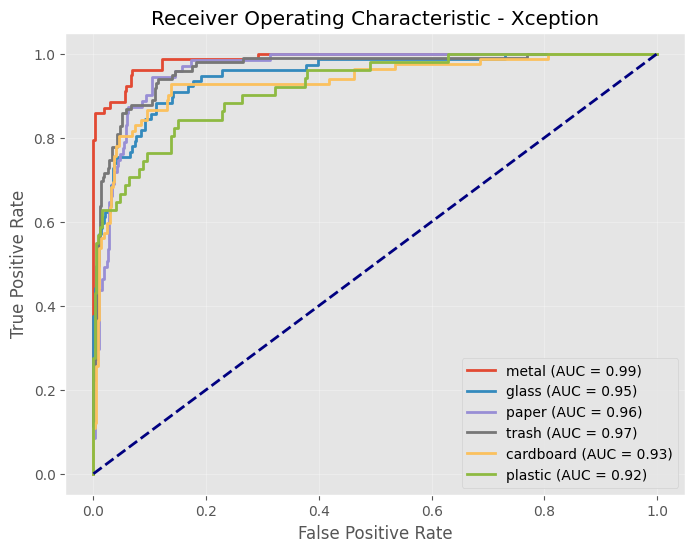

In [59]:
y_true_bin = label_binarize(all_labels, classes=np.arange(N_CLASSES))
    
plt.figure(figsize=(8, 6))
    
for i in range(N_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    label = selectedClasses[i]
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Xception')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [60]:
xception_model.save('xception_model.h5')

# <a id="8"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">8. DenseNet as pre-trained  </div>

In [61]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=( 224, 224, 3))
base_model.trainable = False  


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(len(trainGenerator.class_indices), activation='softmax')(x)  

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [62]:
DenseNet_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
DenseNet_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [67]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=5,
                                                 min_lr=1e-7,
                                                 mode='min')

early_stopping=tf.keras.callbacks.EarlyStopping(patience=15,
                                            monitor='val_accuracy',
                                            restore_best_weights=True)

In [64]:
trainGenerator,valGenerator,testGenerator = Apply_Data_Augmentation(DENSENET_IMG_SIZE)
print(f"Training set size: {trainGenerator.samples}")
print(f"Validation set size: {valGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Found 6434 validated image filenames belonging to 6 classes.
Found 682 validated image filenames belonging to 6 classes.
Found 458 validated image filenames belonging to 6 classes.
Training set size: 6434
Validation set size: 682
Testing set size: 458


In [68]:
history = DenseNet_model.fit(
    trainGenerator,
    validation_data=valGenerator,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.2825 - loss: 1.7364 - val_accuracy: 0.5147 - val_loss: 1.2910 - learning_rate: 1.0000e-04
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 88s 810ms/step - accuracy: 0.5306 - loss: 1.2571 - val_accuracy: 0.6041 - val_loss: 1.0713 - learning_rate: 1.0000e-04
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 88s 811ms/step - accuracy: 0.5916 - loss: 1.1251 - val_accuracy: 0.6305 - val_loss: 0.9978 - learning_rate: 1.0000e-04
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 88s 811ms/step - accuracy: 0.6186 - loss: 1.0362 - val_accuracy: 0.6628 - val_loss: 0.9246 - learning_rate: 1.0000e-04
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 88s 814ms/step - accuracy: 0.6372 - loss: 0.9933 - val_accuracy: 0.6745 - val_loss: 0.8786 - learning_rate: 1.0000e-04
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 88s 814ms/step - accuracy: 0.6606 - loss: 0.9471 - val_accuracy: 0.6701 - val_loss: 0.8664 - learning_rate: 1.0000e-04
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 87s 801ms/step - ac

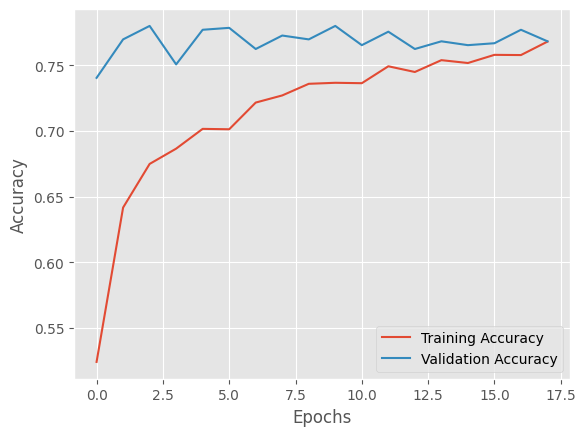

In [69]:
plt.plot(histroy.history['accuracy'],label='Training Accuracy')
plt.plot(histroy.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

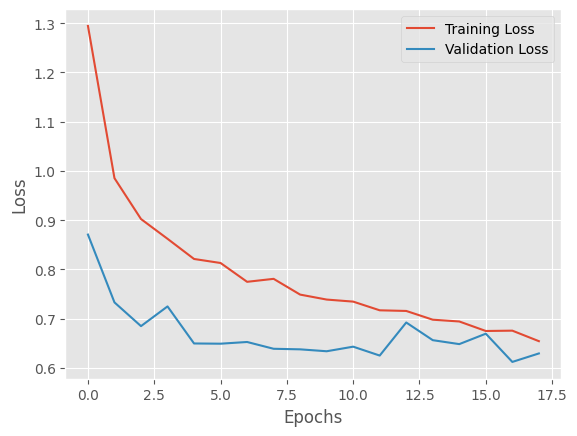

In [70]:
plt.plot(histroy.history['loss'],label='Training Loss')
plt.plot(histroy.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [71]:
test_loss, test_accuracy = DenseNet_model.evaluate(testGenerator)
print(f"Test Accuracy: {test_accuracy:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7617 - loss: 0.6911  
Test Accuracy: 0.77


In [72]:
y_pred = np.argmax(DenseNet_model.predict(testGenerator), axis=-1)
y_true = testGenerator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step 


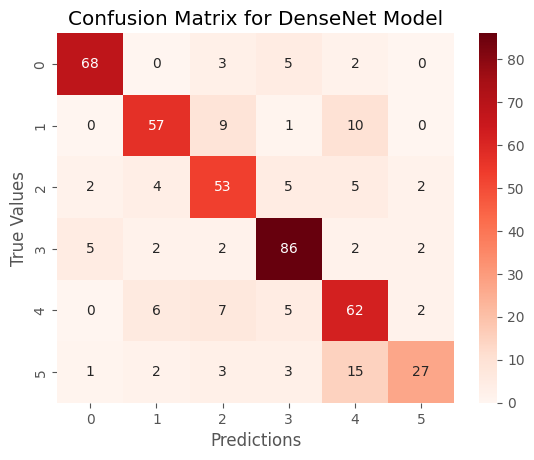

In [78]:
DenseNet_cm = confusion_matrix(y_true, y_pred)
sns.heatmap(DenseNet_cm,fmt='d',cmap='Reds',annot=True ,)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('Confusion Matrix for DenseNet Model')
plt.show()

In [79]:
Dense_ClassificationReport = classification_report(y_true,y_pred)
print('Classification Report for DenseNet Model is : \n', Dense_ClassificationReport)

Classification Report for DenseNet Model is : 
               precision    recall  f1-score   support

           0       0.89      0.87      0.88        78
           1       0.80      0.74      0.77        77
           2       0.69      0.75      0.72        71
           3       0.82      0.87      0.84        99
           4       0.65      0.76      0.70        82
           5       0.82      0.53      0.64        51

    accuracy                           0.77       458
   macro avg       0.78      0.75      0.76       458
weighted avg       0.78      0.77      0.77       458



In [80]:
DenseNet_f1 = f1_score(all_labels, y_pred, average='macro')
DenseNet_precision = precision_score(all_labels, y_pred, average='macro')  
DenseNet_recall = recall_score(all_labels, y_pred, average='macro') 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


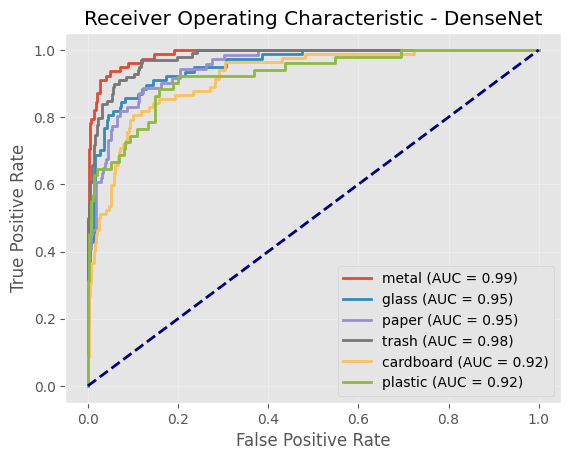

In [84]:
y_true_bin = label_binarize(y_true, classes=np.arange(N_CLASSES))

y_probs = DenseNet_model.predict(testGenerator)

for i in range(N_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    label = selectedClasses[i]
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - DenseNet')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [85]:
DenseNet_model.save('DenseNet_model.h5')

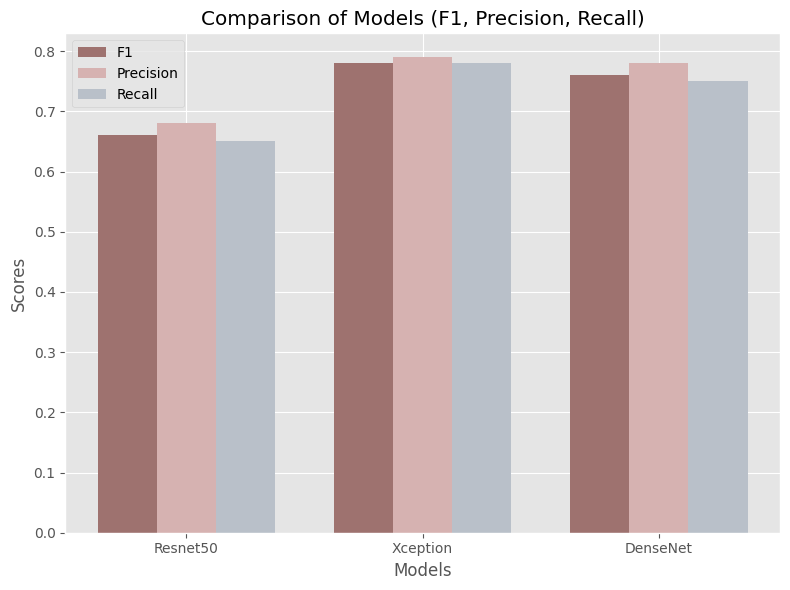

In [86]:

models = ['Resnet50', 'Xception', 'DenseNet']
f1_scores = [round(Resnet50_f1, 2), round(Xception_f1, 2), round(DenseNet_f1, 2)]
precision_scores = [round(Resnet50_precision, 2), round(Xception_precision, 2), round(DenseNet_precision, 2)]
recall_scores = [round(Resnet50_recall, 2), round(Xception_recall, 2), round(DenseNet_recall, 2)]

x = np.arange(len(models))

width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - width, f1_scores, width, label='F1', color="#9E726F")
bars2 = ax.bar(x, precision_scores, width, label='Precision', color="#D6B2B1")
bars3 = ax.bar(x + width, recall_scores, width, label='Recall', color="#B9C0C9")

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Models (F1, Precision, Recall)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()